In [16]:
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("paper", font_scale=1.7)
sns.set_style("ticks", {"axes.grid": True, "grid.color": "0.95", "grid.linestyle": "-"})

# Load data

## Clusters

In [23]:
cluster_class_df = pd.read_feather("../../../../GitHub/HFZoo/data/keys/cluster_classifications.feather")
cluster_class_filter_df = cluster_class_df
classification_order = [
    "Value",
    "Investment",
    "Low Risk",
    "Profitability",
    "Quality",
    "Leverage",
    "Momentum",
    "Size",
    "Profit Growth",
    "Accruals",
    "Debt Issuance",
    "Skewness",
    "Seasonality",
]
assign_alt_df = cluster_class_filter_df.assign(
        classification=pd.Categorical(
            cluster_class_filter_df["cluster_avg"], categories=classification_order, ordered=True
        )
    )
factor_order = (
    assign_alt_df
    .sort_values(by=["classification", "rho_avg"], ascending = [True, False])["factor"]
    .values
)

## Variable names

In [24]:
# List of variable names
variable_names = pd.read_csv('../../results/main_names/variables_names.csv').columns.to_list()

In [25]:
## Unpack variable names and merge with classifications
variable_names_key_df = pd.DataFrame(variable_names, columns=["name"])

def get_regressor_time_label(x):

    key = str(x.split("__")[-1].split("_")[1])
    if key == "1":
        return "15-Minute Lag"
    elif key == "4":
        return "Hour Lag"
    elif key == "1d":
        return "Day Lag"
    else:
        raise Exception("Unknown: ", str(x), " ", key)


variable_names_key_df["factor"] = variable_names_key_df["name"].apply(
    lambda x: "__".join(x.split("__")[:2])
)
variable_names_key_df["component_label"] = variable_names_key_df["name"].apply(
    lambda x: x.split("__")[2].split("_")[0]
)
variable_names_key_df["time_label"] = variable_names_key_df["name"].apply(
    lambda x: get_regressor_time_label(x)
)
variable_names_key_df = variable_names_key_df.merge(assign_alt_df, on=["factor"], how="left")
variable_names_key_df

,name,factor,component_label,time_label,cluster_avg,rho_avg,cluster_max,rho_max,Classification,classification
0,jkp__debt_me__jmp_4_1_lagged_intradaily_avg,jkp__debt_me,jmp,Hour Lag,Value,0.764471,Value,1.000000,Value,Value
1,cz__cashprod__jmp_1_1_lagged_intradaily_avg,cz__cashprod,jmp,15-Minute Lag,Quality,0.629841,Quality,0.870451,Quality,Quality
2,jkp__seas_16_20na__jmp_4_1_lagged_intradaily_avg,jkp__seas_16_20na,jmp,Hour Lag,Seasonality,0.124152,Seasonality,1.000000,Seasonality,Seasonality
3,cz__indretbig__jmp_1d_1_lagged_daily_avg,cz__indretbig,jmp,Day Lag,Momentum,0.071465,Momentum,0.236714,Momentum,Momentum
4,ind48__24_aero__jmp_1d_1_lagged_daily_avg,ind48__24_aero,jmp,Day Lag,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1627,ind48__38_paper__cts_1d_1_lagged_daily_avg,ind48__38_paper,cts,Day Lag,NaN,NaN,NaN,NaN,NaN,NaN
1628,ind48__9_hshld__jmp_1_1_lagged_intradaily_avg,ind48__9_hshld,jmp,15-Minute Lag,NaN,NaN,NaN,NaN,NaN,NaN
1629,cz__betatailrisk__jmp_1_1_lagged_intradaily_avg,cz__betatailrisk,jmp,15-Minute Lag,Leverage,0.300662,Leverage,0.498742,Leverage,Leverage
1630,ff__hml__cts_1_1_lagged_intradaily_avg,ff__hml,cts,15-Minute Lag,NaN,NaN,NaN,NaN,NaN,NaN


## Log

In [26]:
log_df = pd.read_pickle('../../results/main/Enet_log.pkl')

## Prepare data

In [27]:
# Get L1 and L2 penalty info
log_df["hyperparam_alpha"] = log_df["hyperparameters"].apply(
    lambda x: x[0]['lambda']
).astype(float)
log_df["hyperparam_l1ratio"] = log_df["hyperparameters"].apply(
    lambda x: x[0]['l1_ratio']
).astype(float)
log_df["L1"] = log_df["hyperparam_alpha"] * (
    log_df["hyperparam_l1ratio"]
)
log_df["L2"] = log_df["hyperparam_alpha"] * (
    1 - log_df["hyperparam_l1ratio"]
)

In [28]:
# Non-zero parameters
log_df['nonzero_params_count'] = log_df['fitted_parameters'].apply(lambda x: np.sum(x[0] != 0))

In [29]:
# Filter
log_df = log_df.query('date_oos_start >= 2004')

# Main

/tmp/ipykernel_27423/1567363839.py:5: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(-1e5, 6)


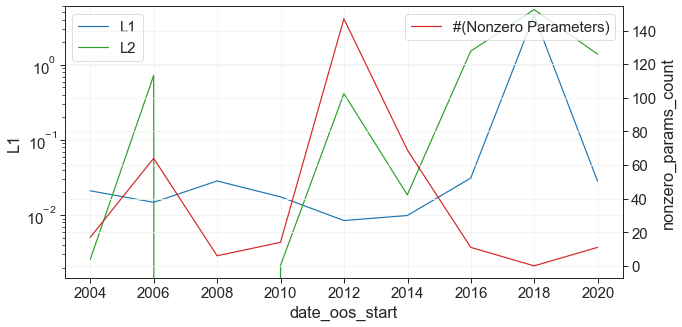

In [30]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(x="date_oos_start", y="L1", label="L1", color="tab:blue", data=log_df, ax=ax)
sns.lineplot(x="date_oos_start", y="L2", label="L2", color="tab:green", data=log_df, ax=ax)
ax.set_yscale("log")
ax.set_ylim(-1e5, 6)

ax2 = ax.twinx()
sns.lineplot(
    x="date_oos_start",
    y="nonzero_params_count",
    label="#(Nonzero Parameters)",
    color="tab:red",
    data=log_df,
    ax=ax2,
)
ax2.set_yscale("linear")

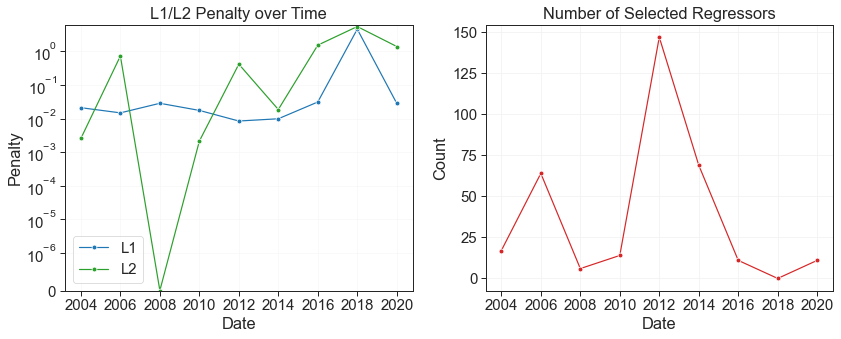

In [31]:
fig, axs = plt.subplots(figsize=(12, 5), ncols=2)
fig.patch.set_alpha(0)

ax = axs[0]
sns.lineplot(
    x="date_oos_start", y="L1", label="L1", color="tab:blue", marker="o", data=log_df, ax=ax
)
sns.lineplot(
    x="date_oos_start", y="L2", label="L2", color="tab:green", marker="o", data=log_df, ax=ax
)
ax.set_yscale("symlog", linthresh=1e-6)
ax.set_ylim(0, 6)
ax.set_xlabel('Date')
ax.set_ylabel('Penalty')
ax.set_title('L1/L2 Penalty over Time')
ax.grid(True, alpha = 0.5)

ax2 = axs[1]
sns.lineplot(
    x="date_oos_start",
    y="nonzero_params_count",
    # label="#(Nonzero Betas)",
    color="tab:red",
    marker="o",
    data=log_df,
    ax=ax2,
)
ax2.set_yscale("linear")
ax2.set_xlabel('Date')
ax2.set_ylabel('Count')
ax2.set_title('Number of Selected Regressors')
ax.grid(True, alpha = 0.5)

plt.tight_layout()
plt.savefig('../../docs/exhibits/figures/hyperparameters_penalty_over_time.pdf')

## By frequency

In [41]:
import pickle

In [42]:
# Results for Elastic Net
with open('../../results/main/Enet_log.pkl', 'rb') as fp:   # Unpickling
    enet_results = pickle.load(fp)

In [43]:
# Parameter estimates
oos_period_labels = [
    "2004-2006",
    "2006-2008",
    "2008-2010",
    "2010-2012",
    "2012-2014",
    "2014-2016",
    "2016-2018",
    "2018-2020",
]

parameters_array = np.zeros([1632, 8])
for i in range(0, 8):
    parameters_array[:, i] = enet_results.iloc[:, 4][i + 4][0]

In [44]:
# As a dataframe
parameters_df = pd.DataFrame(parameters_array.T, index = oos_period_labels, columns = variable_names)
parameters_df

,jkp__debt_me__jmp_4_1_lagged_intradaily_avg,cz__cashprod__jmp_1_1_lagged_intradaily_avg,jkp__seas_16_20na__jmp_4_1_lagged_intradaily_avg,cz__indretbig__jmp_1d_1_lagged_daily_avg,ind48__24_aero__jmp_1d_1_lagged_daily_avg,ff__cma__cts_4_1_lagged_intradaily_avg,cz__earnsupbig__cts_4_1_lagged_intradaily_avg,jkp__prc_highprc_252d__cts_1d_1_lagged_daily_avg,jkp__dsale_dinv__cts_1d_1_lagged_daily_avg,jkp__dolvol_126d__cts_1_1_lagged_intradaily_avg,...,jkp__pi_nix__jmp_4_1_lagged_intradaily_avg,jkp__eqnpo_me__jmp_4_1_lagged_intradaily_avg,ind48__10_clths__jmp_1_1_lagged_intradaily_avg,jkp__prc_highprc_252d__jmp_1_1_lagged_intradaily_avg,jkp__gp_atl1__cts_1_1_lagged_intradaily_avg,ind48__38_paper__cts_1d_1_lagged_daily_avg,ind48__9_hshld__jmp_1_1_lagged_intradaily_avg,cz__betatailrisk__jmp_1_1_lagged_intradaily_avg,ff__hml__cts_1_1_lagged_intradaily_avg,cz__orgcap__jmp_4_1_lagged_intradaily_avg
2004-2006,-0.0,0.00000,-0.0,-0.000000,-0.0,0.0,-0.0,0.0,0.0,0.0,...,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.000000,-0.0
2006-2008,-0.0,-0.00000,-0.0,0.000000,-0.0,-0.0,0.0,0.0,0.0,-0.0,...,-0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.000000,0.0
2008-2010,0.0,0.00000,0.0,0.000000,-0.0,-0.0,0.0,-0.0,0.0,-0.0,...,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.000000,0.0
2010-2012,-0.0,-0.00106,0.0,-0.000176,0.0,-0.0,0.0,0.0,0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.000368,0.0
2012-2014,-0.0,0.00000,0.0,-0.000000,0.0,-0.0,0.0,0.0,-0.0,0.0,...,-0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.000000,-0.0
2014-2016,0.0,0.00000,-0.0,-0.000000,-0.0,0.0,0.0,0.0,-0.0,0.0,...,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.000000,0.0
2016-2018,-0.0,0.00000,0.0,0.000000,0.0,0.0,-0.0,0.0,-0.0,0.0,...,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.000000,0.0
2018-2020,0.0,-0.00000,-0.0,0.000000,0.0,0.0,-0.0,0.0,-0.0,-0.0,...,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.000000,0.0


<AxesSubplot:>

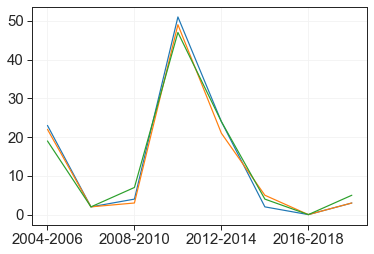

In [54]:
variables_15min = variable_names_key_df.query('time_label == "15-Minute Lag"')['name']
variables_hour = variable_names_key_df.query('time_label == "Hour Lag"')['name']
variables_day = variable_names_key_df.query('time_label == "Day Lag"')['name']
parameters_df[variables_15min].pipe(lambda x: x!=0).sum(axis=1).plot()
parameters_df[variables_hour].pipe(lambda x: x!=0).sum(axis=1).plot()
parameters_df[variables_day].pipe(lambda x: x!=0).sum(axis=1).plot()

<AxesSubplot:>

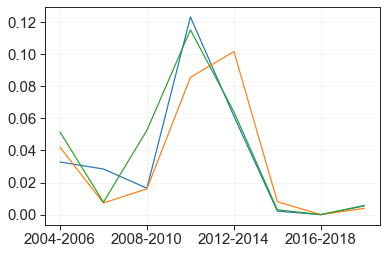

In [72]:
variables_15min = variable_names_key_df.query('time_label == "15-Minute Lag"')['name']
variables_hour = variable_names_key_df.query('time_label == "Hour Lag"')['name']
variables_day = variable_names_key_df.query('time_label == "Day Lag"')['name']
parameters_df[variables_15min].pipe(lambda x: np.abs(x)).sum(axis=1).plot()
parameters_df[variables_hour].pipe(lambda x: np.abs(x)).sum(axis=1).plot()
parameters_df[variables_day].pipe(lambda x: np.abs(x)).sum(axis=1).plot()

<AxesSubplot:>

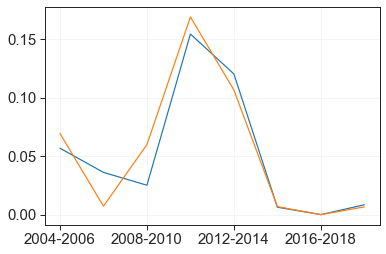

In [73]:
variables_cts = variable_names_key_df.query('component_label == "cts"')['name']
variables_jmp = variable_names_key_df.query('component_label == "jmp"')['name']
parameters_df[variables_cts].pipe(lambda x: np.abs(x)).sum(axis=1).plot()
parameters_df[variables_jmp].pipe(lambda x: np.abs(x)).sum(axis=1).plot()

In [66]:
x = parameters_df[variables_15min].pipe(lambda x: x!=0).iloc[0,:]
x[x].sort_values()

jkp__age__cts_1_1_lagged_intradaily_avg              True
jkp__op_at__jmp_1_1_lagged_intradaily_avg            True
jkp__ni_be__jmp_1_1_lagged_intradaily_avg            True
ind48__6_toys__cts_1_1_lagged_intradaily_avg         True
jkp__at_gr1__cts_1_1_lagged_intradaily_avg           True
jkp__seas_16_20na__cts_1_1_lagged_intradaily_avg     True
jkp__be_gr1a__cts_1_1_lagged_intradaily_avg          True
cz__volumetrend__jmp_1_1_lagged_intradaily_avg       True
jkp__seas_16_20an__cts_1_1_lagged_intradaily_avg     True
cz__exchswitch__jmp_1_1_lagged_intradaily_avg        True
ind48__29_coal__cts_1_1_lagged_intradaily_avg        True
jkp__sale_bev__cts_1_1_lagged_intradaily_avg         True
cz__varcf__cts_1_1_lagged_intradaily_avg             True
cz__herf__cts_1_1_lagged_intradaily_avg              True
jkp__eqnpo_12m__jmp_1_1_lagged_intradaily_avg        True
jkp__pi_nix__cts_1_1_lagged_intradaily_avg           True
jkp__seas_6_10an__jmp_1_1_lagged_intradaily_avg      True
jkp__lti_gr1a_

In [67]:
x = parameters_df[variables_hour].pipe(lambda x: x!=0).iloc[0,:]
x[x].sort_values()

jkp__aliq_at__jmp_4_1_lagged_intradaily_avg                 True
cz__indretbig__jmp_4_1_lagged_intradaily_avg                True
cz__shareiss5y__jmp_4_1_lagged_intradaily_avg               True
jkp__niq_be_chg1__jmp_4_1_lagged_intradaily_avg             True
jkp__bidaskhl_21d__cts_4_1_lagged_intradaily_avg            True
jkp__opex_at__jmp_4_1_lagged_intradaily_avg                 True
jkp__cop_atl1__jmp_4_1_lagged_intradaily_avg                True
jkp__ivol_hxz4_21d__jmp_4_1_lagged_intradaily_avg           True
ind48__32_telcm__cts_4_1_lagged_intradaily_avg              True
cz__earnsupbig__jmp_4_1_lagged_intradaily_avg               True
jkp__ocfq_saleq_std__jmp_4_1_lagged_intradaily_avg          True
cz__shortinterest__cts_4_1_lagged_intradaily_avg            True
cz__idiorisk__cts_4_1_lagged_intradaily_avg                 True
cz__chinvia__jmp_4_1_lagged_intradaily_avg                  True
ind48__33_persv__jmp_4_1_lagged_intradaily_avg              True
jkp__saleq_gr1__jmp_4_1_l

In [68]:
x = parameters_df[variables_day].pipe(lambda x: x!=0).iloc[0,:]
x[x].sort_values()

cz__orderbacklog__cts_1d_1_lagged_daily_avg           True
jkp__capx_gr2__cts_1d_1_lagged_daily_avg              True
cz__chnwc__cts_1d_1_lagged_daily_avg                  True
jkp__ivol_capm_252d__jmp_1d_1_lagged_daily_avg        True
jkp__aliq_mat__cts_1d_1_lagged_daily_avg              True
jkp__dolvol_var_126d__cts_1d_1_lagged_daily_avg       True
cz__varcf__cts_1d_1_lagged_daily_avg                  True
ind48__26_guns__jmp_1d_1_lagged_daily_avg             True
ff__umd__cts_1d_1_lagged_daily_avg                    True
ff__rmw__jmp_1d_1_lagged_daily_avg                    True
jkp__ncol_gr1a__cts_1d_1_lagged_daily_avg             True
jkp__ocfq_saleq_std__jmp_1d_1_lagged_daily_avg        True
jkp__qmj_safety__cts_1d_1_lagged_daily_avg            True
jkp__seas_16_20na__jmp_1d_1_lagged_daily_avg          True
jkp__netdebt_me__jmp_1d_1_lagged_daily_avg            True
jkp__capex_abn__jmp_1d_1_lagged_daily_avg             True
cz__earningsconsistency__jmp_1d_1_lagged_daily_avg    Tr

In [60]:
variables_day.sort_values()

775      cz__abnormalaccruals__cts_1d_1_lagged_daily_avg
1137     cz__abnormalaccruals__jmp_1d_1_lagged_daily_avg
28                  cz__adexp__cts_1d_1_lagged_daily_avg
162                 cz__adexp__jmp_1d_1_lagged_daily_avg
1059               cz__ageipo__cts_1d_1_lagged_daily_avg
                              ...                       
96      jkp__zero_trades_126d__jmp_1d_1_lagged_daily_avg
1597     jkp__zero_trades_21d__cts_1d_1_lagged_daily_avg
1265     jkp__zero_trades_21d__jmp_1d_1_lagged_daily_avg
1062    jkp__zero_trades_252d__cts_1d_1_lagged_daily_avg
1132    jkp__zero_trades_252d__jmp_1d_1_lagged_daily_avg
Name: name, Length: 544, dtype: object